<a href="https://colab.research.google.com/github/step-cheng/CIFAR10-pytorch/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install torch>=2.0.1
# !pip install torchvision
# !pip install -Uqq ipdb

In [1]:
!git clone https://github.com/step-cheng/CIFAR10-pytorch.git
# %cd CIFAR10-pytorch
# !git pull
# %cd ..

Cloning into 'CIFAR10-pytorch'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 115 (delta 53), reused 62 (delta 25), pack-reused 0
Receiving objects: 100% (115/115), 1.54 MiB | 4.75 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
# Turn on Google Colab Debugger
# %pdb on
# %pdb off

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
# import ipdb

In [3]:
import sys
sys.path.append('/content/CIFAR10-pytorch')
from models import *
from utils import accuracy

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 263MB/s]
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:16<00:00, 34.0MB/s]


In [4]:
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914,0.4822,0.4465), (0.2470, 0.2435, 0.2616))])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4942, 0.4851, 0.4504), (0.2467, 0.2429, 0.2616))])

target_transform = None
# target_transform = transforms.Lambda(lambda y : torch.zeros(10,dtype=torch.float).scatter(dim=0, index=torch.tensor(y),value=1))

# 50000 train images
train_data = datasets.CIFAR10(root='./', train=True, download=True, transform=transform_train, target_transform=target_transform)
# DataLoader wraps an iterable over dataset for automatic batching, sampling, and dataloading
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

# 10000 test images
test_data = datasets.CIFAR10(root='./', train=False, download=True, transform=transform_test, target_transform=target_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

classes = {
    0 : 'plane',    1 : 'car',    2 : 'bird',   3 : 'cat',    4 : 'deer',
    5 : 'dog',      6 : 'frog',   7 : 'horse',  8 : 'ship',   9 : 'truck'
}

100%|██████████| 170498071/170498071 [00:04<00:00, 38118780.09it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
# img, label = training_data[1]
train_iter = iter(train_loader)
img, label = next(train_iter)
# print(img.shape)
# print(label.shape)

# shows image tensor
def show(tens, label):
  # make_grid makes a grid of images from a batch of tensors BxCxHxW
  img = torchvision.utils.make_grid(tens) # flattens B dimension to make a grid
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1,2,0)))     # seems each image is spaced by 2 pixels, channels goes last when plotting
  title = ' '.join([classes[t.item()] for t in label])
  plt.title(title)

# show(img, label)


In [22]:
def train(dataloader, model, device, loss_fn, optimizer):
  # sets the module to training mode, eval does the opposite
  model.train()

  accs = []
  losses = []
  matches = 0

  for batch, (X, y) in enumerate(dataloader):
    imgs, labels = X.to(device), y.to(device)

    pred = model(imgs)
    loss = loss_fn(pred, labels)
    acc, m = accuracy(pred, labels)

    losses.append(loss.item())
    accs.append(acc)
    matches += m
    if batch % 50 == 0:
      print(f"Progress: {(batch+1) * len(X)}, current accuracy: {m/len(X)}")

    loss.backward()
    # print(model.classifier[2].weight[:,0])
    # print(model.classifier[2].weight.grad[:,0])
    optimizer.step()
    optimizer.zero_grad()

  # f, (ax1,ax2) = plt.subplots(1,2)
  # ax1.plot(torch.arange(batch+1),losses)
  # ax2.plot(torch.arange(batch+1),accs)
  # ax1.set_title("Loss vs Epoch")
  # ax1.set_ylabel("Loss")
  # ax1.set_xlabel("Epoch")
  # ax2.set_title("Accuracy vs Epoch")
  # ax2.set_ylabel("Accuracy")
  # ax2.set_xlabel("Epoch")

  print(f"Epoch Accuracy: {matches/50000}")
  return losses, accs



In [15]:
def test(dataloader, model, device):

  # set module to testing mode, train does the opposite
  model.eval()
  accs = []
  matches = 0

  # used to turn off gradient calculations
  with torch.no_grad():
    for batch, (X,y) in enumerate(dataloader):
      imgs, labels = X.to(device), y.to(device)

      pred = model(imgs)
      acc, m = accuracy(pred,labels)
      matches += m

      if batch % 50 == 0:
        print(f"Progress: {(batch+1)*len(X)}, current accuracy: {m/len(X)}")
        accs.append(acc)

  print(f"Test Accuracy: {matches/10000}")

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Pytorch version: {torch.__version__}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available.")

Pytorch version: 2.0.1+cu118
Device name: Tesla T4


In [38]:
model = mymodel.myNN().to(device)
# model.half() # If doing this, input type and weight type need to be the same

# set cross entropy loss and Adam optimizer functions
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.005)
lr_sch = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)
# lr_sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=14, gamma=0.1)

Epoch 1, learning rate [0.001]
Progress: 128, current accuracy: 0.09375
Progress: 6528, current accuracy: 0.4375
Progress: 12928, current accuracy: 0.4765625
Progress: 19328, current accuracy: 0.484375
Progress: 25728, current accuracy: 0.5234375
Progress: 32128, current accuracy: 0.4609375
Progress: 38528, current accuracy: 0.5703125
Progress: 44928, current accuracy: 0.578125
Epoch Accuracy: 0.48192
Progress: 128, current accuracy: 0.5703125
Progress: 6528, current accuracy: 0.5546875
Test Accuracy: 0.5731
Epoch 2, learning rate [0.000996057350657239]
Progress: 128, current accuracy: 0.59375
Progress: 6528, current accuracy: 0.515625
Progress: 12928, current accuracy: 0.5390625
Progress: 19328, current accuracy: 0.65625
Progress: 25728, current accuracy: 0.625
Progress: 32128, current accuracy: 0.6015625
Progress: 38528, current accuracy: 0.5859375
Progress: 44928, current accuracy: 0.6015625
Epoch Accuracy: 0.62326
Progress: 128, current accuracy: 0.609375
Progress: 6528, current ac

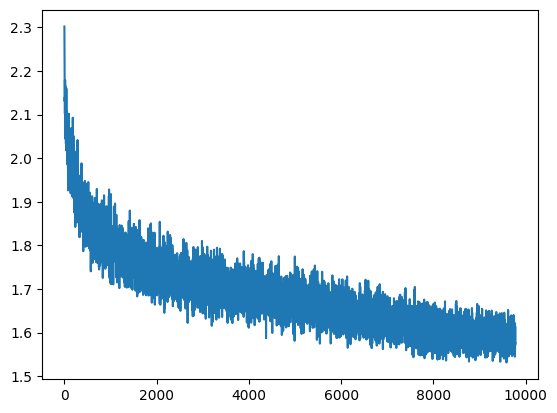

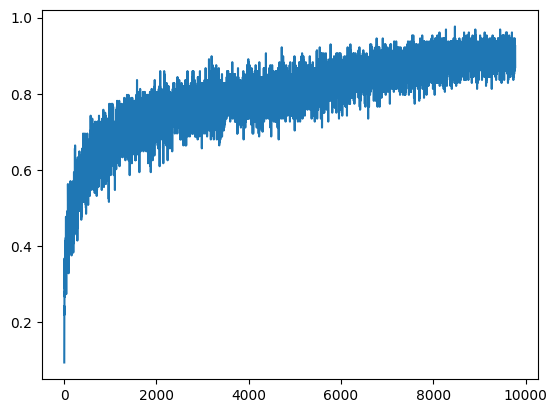

In [37]:
epochs = 25
start = datetime.now()
losses_ = []
accuracies_ = []
for e in range(epochs):
  print(f"Epoch {e+1}, learning rate {lr_sch.get_last_lr()}")
  losses, accuracies = train(train_loader, model, device, loss_fn, optimizer)
  losses_.extend(losses)
  accuracies_.extend(accuracies)
  test(test_loader,model,device)
  # return losses and accuracy, compile into big graph
  optimizer.step()
  lr_sch.step()
elapse = datetime.now() - start
print("Training Time: ", elapse)
plt.figure()
plt.plot(torch.arange(1,len(losses_)+1), losses_)
plt.figure()
plt.plot(torch.arange(1,len(accuracies_)+1), accuracies_)
